## Fune-tune the System - Decision Tree Classifier

In [1]:
# setting

import sys
sys.path.append("..")

from module.utils import general_utils
from module.utils import data_prepare_utils
from module.utils import model_performance_utils
import module.utils.bin_class_utils as bin_class_utils

from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
target_attr = "label"
target_type = "binary"

estimator_name = "DecisionTreeClassifier"

sample_random_state = 24
target_encoding_random_state = 42
model_random_state = 42
permutation_importance_random_state = 0

In [3]:
train_df = pd.read_csv('train_df_exp.csv')
train_cap_x_df, train_y_df = train_df.drop(columns=target_attr), train_df[[target_attr]]

balanced = train_y_df.shape[0] / (train_y_df[target_attr].nunique()*np.bincount(train_y_df[target_attr]))
balanced_and_normalized_dict = \
    dict(
        zip(
            train_y_df[target_attr].unique(),
            balanced/sum(balanced)
            )
        )

In [4]:
numerical_attr_list = []
categorical_attr_list = [attr for attr in train_cap_x_df.columns if attr not in numerical_attr_list and attr != target_attr]
attr_list = numerical_attr_list + categorical_attr_list

In [5]:
attrs_to_drop = ['app_score', 'his_on_shelf_time', 'task_id', 'spread_app_id', 'tags', 'dev_id', 'app_second_class', 'adv_prim_id', 'device_price']
preprocessor = bin_class_utils.build_preprocessing_pipeline(numerical_attr_list, categorical_attr_list, attrs_to_drop, target_type, target_encoding_random_state)
estimator = DecisionTreeClassifier(random_state=model_random_state, class_weight=balanced_and_normalized_dict)
dt_pipe = Pipeline([('preprocessor', preprocessor), ('estimator', estimator)])

#### 0. Tune Hyperparameters of Composite Estimator - Ranking Metrics

In [6]:
best_model = bin_class_utils.tune_hyperparameters_dt(train_cap_x_df, train_y_df, dt_pipe)

Best estimator: {'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'preprocessor__categorical__target_encoder__smooth': 'auto', 'preprocessor__numerical__imputer__strategy': 'mean'}
accuracy: 0.9397374701670644
ave_precision_score: 0.04753580007223434
roc_curve_auc: 0.5513418040839638


#### 1. Evaluate Tuned Composite Estimators

Check accuracy score
train set set accuracy score: 0.9397374701670644

Check confusion matrix
train set set confusion matrix: 
[[6269  204]
 [ 200   31]]
True Positives =  6269
True Negatives =  31
False Positives(Type I error) =  204
False Negatives(Type II error) =  200

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6473
           1       0.13      0.13      0.13       231

    accuracy                           0.94      6704
   macro avg       0.55      0.55      0.55      6704
weighted avg       0.94      0.94      0.94      6704


Check the ROC Curve and AUC


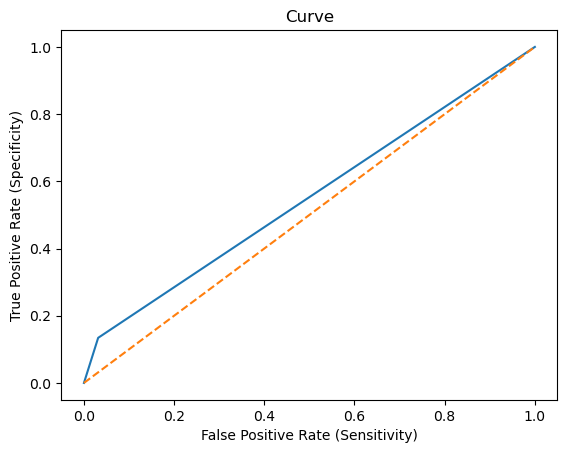


Check Precision-Recall Curve and Average Precision Score


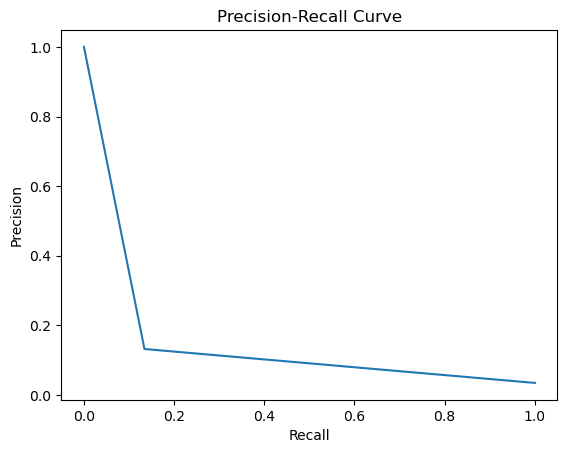

The roc_auc_score:  0.5513418040839638
Average Precision Score:  0.04753580007223434


In [7]:
roc_auc, ave_precision = \
    bin_class_utils.eval_class_tuned(train_cap_x_df, train_y_df, best_model, 'train set')

In [8]:
validation_df = pd.read_csv('validation_df_exp.csv')
validation_cap_x_df, validation_y_df = validation_df.drop(columns=target_attr), validation_df[[target_attr]]

Check accuracy score
validation set set accuracy score: 0.9350029815146095

Check confusion matrix
validation set set confusion matrix: 
[[1564   55]
 [  54    4]]
True Positives =  1564
True Negatives =  4
False Positives(Type I error) =  55
False Negatives(Type II error) =  54

Check classification report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1619
           1       0.07      0.07      0.07        58

    accuracy                           0.94      1677
   macro avg       0.52      0.52      0.52      1677
weighted avg       0.94      0.94      0.94      1677


Check the ROC Curve and AUC


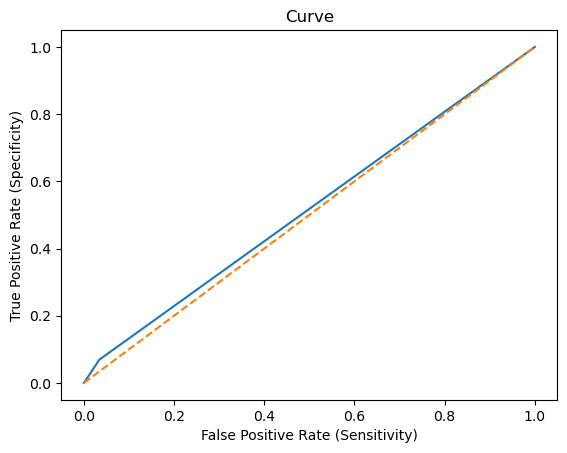


Check Precision-Recall Curve and Average Precision Score


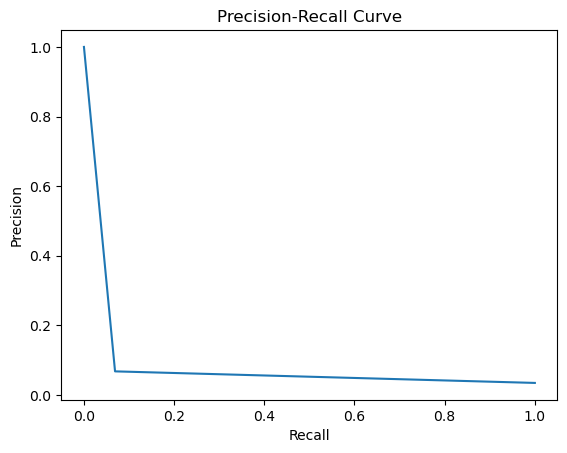

The roc_auc_score:  0.5174969649208749
Average Precision Score:  0.03687598606930427


In [9]:
val_roc_auc, val_ave_precision = \
    bin_class_utils.eval_class_tuned(validation_cap_x_df, validation_y_df, best_model, 'validation set')

#### 2. Calibrate Composite Estimator If Required

#### 3. Check for False Discoveries

#### 4. Selection a Model

#### 5. Permutation Feature Importance

#### 6. Tune Classification Threshold for Classification - Classification Metrics

#### 7. Serialize Model and Classification Threshold

#### 8. Evaluate Model on the Test Set